# Adaptative Feature Extraction

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import pandas as pd
import math
import glob
import os
from sklearn.impute import KNNImputer

# ROI Extraction

In [9]:
def trainset_extra():
    ROI = []
    filenames = []
    trainset = pd.read_csv('trainset/trainset.csv')
    for e in [r'trainset/*.png']:    
        for filepath in glob.iglob(e): 

            filename= filepath.split(os.path.sep)[-1]
            img = cv2.imread('trainset/'+filename)

            f = filename.replace(".png","")
            idx = np.where(trainset["filename"]==f)[0][0]
            n_img = img[int(trainset[" y_24"][idx]-70):int(trainset[" y_8"][idx]+10),int(trainset[" x_0"][idx]):int(trainset[" x_16"][idx])]

            filenames.append(filename)
            ROI.append(n_img)
    return filenames, ROI

def testset_extra():
    ROI = []
    filenames = []
    testset = pd.read_csv('testset/testset.csv')
    for e in [r'testset/*.png']:    
        for filepath in glob.iglob(e): 

            filename= filepath.split(os.path.sep)[-1]
            img = cv2.imread('testset/'+filename)

            f = filename.replace(".png","")

            idx = np.where(testset["filename"]==f)[0][0]
            n_img = img[int(testset[" y_24"][idx]-70):int(testset[" y_8"][idx]+10),int(testset[" x_0"][idx]):int(testset[" x_16"][idx])]

            filenames.append(filename)
            ROI.append(n_img)
    return filenames, ROI

def ROI_extraction(setT):
#    ROI = []
#    filenames = []
    s = 0
    if setT == "trainset":
        s = 1
        print("ROI extraction on trainset")
    elif setT == "testset":
        s = 0
        print("ROI extraction on testset")
    else : 
        print("parameter must be trainset or testset")
        
    if s == 1 :
        filenames, ROI = trainset_extra()
    elif s == 0 :
        filenames, ROI = testset_extra()
        
    return ROI, filenames

In [10]:
ROI, filenames = ROI_extraction('trainset')

ROI extraction on trainset


In [11]:
ROITS, filenamesTS = ROI_extraction('testset')

ROI extraction on testset


# Feature Extraction

In [12]:
import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

In [13]:
def feature_extraction(ROI):
    if not isinstance(ROI,list):
        print("Roi type must be list of numpy.array images") 
        return 0
    fd, hog_img = [],[]
    for e in range(len(ROI)):
        #print(e)
        # Calculate parameters 
        #alldiv = list(divisorGenerator(ROI[e].shape[0]))
        #div = 1
        #for i in range(len(alldiv)):
        #    if alldiv[i]<3 :
        #        div = alldiv[i]
        #ppc=math.gcd(round(ROI[e].shape[0]/div),ROI[e].shape[1])

        # Implementing HOG feature
        #print("ppc",ppc)
        ppc = 10
        a,b = hog(ROI[e], orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(1, 1), visualize=True, multichannel=True,feature_vector=True)
        fd.append(a)
        hog_img.append(b)
    return fd,hog_img

### Example

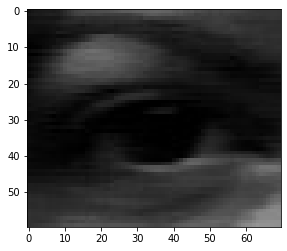

In [14]:
img = cv2.imread('trainset/S010_001_00000001.png')
n_img = img[190:250,280:350]
n_img.shape[1]
a = [n_img,n_img]
list(divisorGenerator(a[0].shape[0]))
plt.imshow(n_img)

378


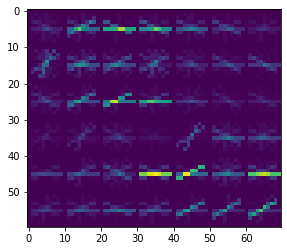

In [15]:
fd,hog_img = feature_extraction(a)
plt.imshow(hog_img[1])
print(len(fd[0]))

In [16]:
%time _ = fd, hog_img = feature_extraction(ROI)

Wall time: 1min 20s


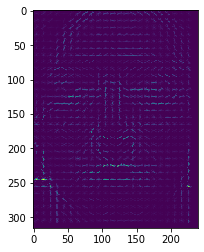

In [17]:
plt.imshow(hog_img[5])

In [18]:
max(map(len, fd))

9450

In [19]:
len(fd[3])

6417

In [20]:
def normalize_size(feat_desc):
    n_arr = []
    tmp = []
    for i in range(len(feat_desc)):
        for j in range(max(map(len, feat_desc))):
            if j >= len(feat_desc[i]):
                tmp.append(np.nan)
            else :
                tmp.append(feat_desc[i][j])
        n_arr.append(tmp)
        tmp = []
    return n_arr

In [21]:
fd1 = normalize_size(fd)

In [22]:
len(fd1)

722

In [23]:
arr = np.array(fd1)
dataf = pd.DataFrame(arr)
dataf

,0,1,2,3,4,5,6,7,8,9,...,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449
0,0.377922,0.284623,0.377922,0.377922,0.377922,0.377922,0.377922,0.249077,0.000000,0.376627,...,0.225635,0.463673,0.128284,0.251206,0.463673,0.463673,0.15093,0.329228,0.25934,0.277548
1,0.351057,0.351057,0.351057,0.351057,0.351057,0.351057,0.351057,0.351057,0.118614,0.348124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.366888,0.366888,0.366888,0.366888,0.366888,0.366888,0.306595,0.249046,0.190619,0.528614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.397388,0.254788,0.200981,0.397388,0.397388,0.397388,0.397388,0.317778,0.064201,0.421881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.438970,0.184419,0.085471,0.026047,0.519917,0.519917,0.371461,0.166035,0.243172,0.395691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.444697,0.444697,0.444697,0.444697,0.326033,0.196110,0.028727,0.175723,0.180331,0.493773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,0.368034,0.368034,0.368034,0.368034,0.368034,0.368034,0.193933,0.368034,0.119357,0.411111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,0.389922,0.389922,0.389922,0.389922,0.389922,0.316540,0.149068,0.123971,0.319401,0.437585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,0.382900,0.382900,0.382900,0.382900,0.382900,0.382900,0.225384,0.157325,0.211601,0.476250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
imputer = KNNImputer(n_neighbors=5)
arr = imputer.fit_transform(dataf[dataf.columns[0:9449]])

In [25]:
dataf = pd.DataFrame(arr)
dataf.isnull().sum().sum()

0

In [26]:
dataf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448
0,0.377922,0.284623,0.377922,0.377922,0.377922,0.377922,0.377922,0.249077,0.000000,0.376627,...,0.308336,0.225635,0.463673,0.128284,0.251206,0.463673,0.463673,0.15093,0.329228,0.25934
1,0.351057,0.351057,0.351057,0.351057,0.351057,0.351057,0.351057,0.351057,0.118614,0.348124,...,0.308336,0.225635,0.463673,0.128284,0.251206,0.463673,0.463673,0.15093,0.329228,0.25934
2,0.366888,0.366888,0.366888,0.366888,0.366888,0.366888,0.306595,0.249046,0.190619,0.528614,...,0.308336,0.225635,0.463673,0.128284,0.251206,0.463673,0.463673,0.15093,0.329228,0.25934
3,0.397388,0.254788,0.200981,0.397388,0.397388,0.397388,0.397388,0.317778,0.064201,0.421881,...,0.308336,0.225635,0.463673,0.128284,0.251206,0.463673,0.463673,0.15093,0.329228,0.25934
4,0.438970,0.184419,0.085471,0.026047,0.519917,0.519917,0.371461,0.166035,0.243172,0.395691,...,0.308336,0.225635,0.463673,0.128284,0.251206,0.463673,0.463673,0.15093,0.329228,0.25934


# On TESTSET

In [27]:
fdTS, hog_imgTS = feature_extraction(ROITS)

In [28]:
len(fdTS)

126

In [87]:
max(map(len, fdTS))

8100

In [29]:
fdTS = normalize_size(fdTS)

In [30]:
len(fdTS)

126

In [31]:
arr = np.array(fdTS)
print(len(arr[0]))
dataTS = pd.DataFrame(arr)
dataTS

8100


,0,1,2,3,4,5,6,7,8,9,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.429353,0.054662,0.429353,0.429353,0.429353,0.429353,0.249474,0.070397,0.090004,0.397933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.386141,0.386141,0.379734,0.386141,0.386141,0.342923,0.158125,0.328067,0.095690,0.270517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.397605,0.244609,0.397605,0.397605,0.397605,0.397605,0.337958,0.174885,0.070136,0.140787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.382401,0.382401,0.309126,0.382401,0.382401,0.382401,0.362667,0.047454,0.198764,0.273321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.375563,0.375563,0.375563,0.375563,0.375563,0.030776,0.108251,0.375563,0.375563,0.320703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.425844,0.425844,0.425844,0.378459,0.425844,0.068965,0.192560,0.252441,0.160732,0.497446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,0.262344,0.290235,0.316871,0.430649,0.430649,0.430649,0.430649,0.068555,0.000000,0.388424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,0.377812,0.377312,0.360442,0.182565,0.377812,0.377812,0.260491,0.361990,0.259365,0.370282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,0.319051,0.079347,0.186035,0.278141,0.495245,0.495245,0.495245,0.188652,0.092445,0.357068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
imputer = KNNImputer(n_neighbors=5)
arr = imputer.fit_transform(dataTS[dataTS.columns[0:9450]])
print(len(arr[0]))
dataTS = pd.DataFrame(arr)
print(dataf.isnull().sum().sum())
dataTS

8100
0


,0,1,2,3,4,5,6,7,8,9,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.429353,0.054662,0.429353,0.429353,0.429353,0.429353,0.249474,0.070397,0.090004,0.397933,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
1,0.386141,0.386141,0.379734,0.386141,0.386141,0.342923,0.158125,0.328067,0.095690,0.270517,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
2,0.397605,0.244609,0.397605,0.397605,0.397605,0.397605,0.337958,0.174885,0.070136,0.140787,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
3,0.382401,0.382401,0.309126,0.382401,0.382401,0.382401,0.362667,0.047454,0.198764,0.273321,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
4,0.375563,0.375563,0.375563,0.375563,0.375563,0.030776,0.108251,0.375563,0.375563,0.320703,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.425844,0.425844,0.425844,0.378459,0.425844,0.068965,0.192560,0.252441,0.160732,0.497446,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
122,0.262344,0.290235,0.316871,0.430649,0.430649,0.430649,0.430649,0.068555,0.000000,0.388424,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
123,0.377812,0.377312,0.360442,0.182565,0.377812,0.377812,0.260491,0.361990,0.259365,0.370282,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033
124,0.319051,0.079347,0.186035,0.278141,0.495245,0.495245,0.495245,0.188652,0.092445,0.357068,...,0.442368,0.280049,0.117648,0.383699,0.788125,0.330311,0.157745,0.062711,0.037789,0.004033


In [33]:
from sklearn.decomposition import PCA
pca = PCA()
pca1 = PCA()
pca.fit(dataf)
pca1.fit(dataTS)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [34]:
var=np.cumsum(pca.explained_variance_ratio_)
var1=np.cumsum(pca1.explained_variance_ratio_)

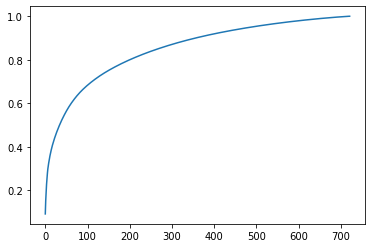

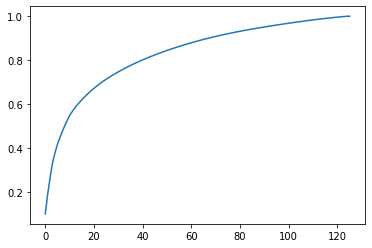

In [35]:
plt.plot(var)
plt.show()
plt.plot(var1)
plt.show()

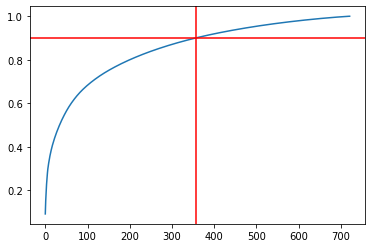

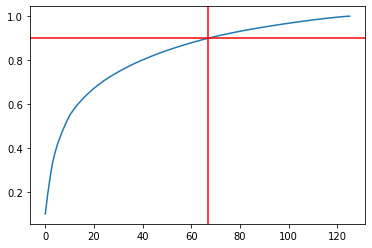

In [42]:
plt.plot(var)
plt.axhline(y=0.9, color='r', linestyle='-')
plt.axvline(x=356, color='r', linestyle='-')
plt.show()
plt.plot(var1)
plt.axhline(y=0.9, color='r', linestyle='-')
plt.axvline(x=67, color='r', linestyle='-')
plt.show()

In [44]:
print(np.argmax(var > 0.9))
print(np.argmax(var1 > 0.9))

356
67


In [47]:
pca = PCA(n_components=356)
reduced = pca.fit_transform(dataf)
recovered = pd.DataFrame(data = reduced)

pca1 = PCA(n_components=67)
reduced1 = pca1.fit_transform(dataTS)
recovered1 = pd.DataFrame(data = reduced1)

In [49]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

In [50]:
def unique_independant_subject(X):
    
    #Extracting only the name of the subject (column 'filename')
    filenames = X.iloc[:, 0]
    #filenames.head(5)
    
    #Save a copy of the trainset in 'trainsetCpy'
    XCpy = X.copy()
    #We replace the column 'filename' with the id of each subject. The id is composed  by the first 4 characters.
    XCpy.loc[XCpy['filename'].notnull(), 'filename'] = ""
    for i in range (0, 4): 
        XCpy.loc[XCpy['filename'].notnull(), 'filename'] += X['filename'].str[i]
    #XCpy.head(5)
    
    #We shuffle randomly the dataset in order to do the separation subject independant properly and for any order of the rows
    xshuffle = XCpy.sample(frac=1)
    #xshuffle.head(5)
  
    #We extract all the unique people in the trainset
    unique_users = xshuffle['filename'].unique()
    #print(unique_users)
    #print("There is ", len(unique_users), " unique people in the trainset")
    
    #We split the unique users with 80% in train and 20% in validation
    #We will test our model on the validation before the prediction on the real testset
    trainset_train_unique, trainset_validation_unique = np.split(np.random.permutation(unique_users), [int(.8 * len(unique_users))])
    #print("There is ", len(trainset_train_unique), " unique people in the trainset_train_unique")
    #print("There is ", len(trainset_validation_unique), " unique people in the trainset_validation_unique")
    
    #---------------------------------------------------------------------
    
    #We recreate the dataset corresponding to the unique users
    trainset_train = X.copy() #trainset_train is the final data set for real training containing images for unique people
    trainset_validation = X.copy() #trainset_validation is the final data set for validation containing images for unique people
    #count1 = 0
    #count2 = 0

    #We put all the values of column 'filename' to empty string
    trainset_train.loc[XCpy['filename'].notnull(), 'filename'] = "" 
    trainset_validation.loc[XCpy['filename'].notnull(), 'filename'] = "" 

    #We loop the whole trainset using iteritems(). columnName is the name of the column
    #and columnData in a sort of list of each value of the columnn

    #
    for (columnName, columnData) in X.iteritems():
        #We want only the column 'filename'
        if(columnName == 'filename'):

            #We select each unique subject in the train_set
            for j in trainset_train_unique:
                #print("unique_users_train", j)

                #We select all the subject (complete value. Ex: S005_001_00000001) in the trainset
                for i in range(len(columnData.values)):
                    #We put the value in the variable 'select_users'
                    select_users = columnData.values[i]
                    #print("Select_users", select_users[0:4])

                    #We select only the first four characters corresponding to the unique id of the subjects
                    #and if the unique value equals the subset,
                    if(j == select_users[0:4]):
                        #we get all the rows
                        trainset_train.iloc[i, 0] = select_users
                        #count1 = count1+1
                    else:
                        #print("Not corresponding")
                        pass

            #We select each unique subject in the validation_set
            for k in trainset_validation_unique:
                #print("unique_users_val", k)

                #We select all the subject (complete value. Ex: S005_001_00000001) in the trainset
                for l in range(len(columnData.values)):
                    #We put the value in the variable 'select_users'
                    select_users = columnData.values[l]
                    #print("Select_users", select_users[0:4])

                    #We select only the first four characters corresponding to the unique id of the subjects
                    #and if the unique value equals the subset,
                    if(k == select_users[0:4]):
                        #we get all the rows
                        trainset_validation.iloc[l, 0] = select_users
                        #count2 = count2+1
                    else:
                        #print("Not corresponding")
                        pass

    #print(count1, count2) 
    
    #Here there are empty value for the column 'filename' because above, we took the whole line for trainset_train
    #trainset_train.head(5)
    #Here there are empty value for the column 'filename' because above, we took the whole line for validation_train
    #trainset_validation.head(5) 
    
    #We replace these empty values by nan for both train and validation
    trainset_train['filename'].replace('', np.nan, inplace=True)
    trainset_validation['filename'].replace('', np.nan, inplace=True)

    #And we drop the nan values for both train and validation
    trainset_train.dropna(subset=['filename'], inplace=True)
    trainset_validation.dropna(subset=['filename'], inplace=True)
    
    #Finaly every images in the dataset are unique
    #trainset_train.head(5)
    
    #Finaly every images in the dataset are unique
    #trainset_validation.head(5)

    return trainset_train, trainset_validation

In [53]:
# Load train dataset in the noteBook
trainset = pd.read_csv('trainset/trainset.csv')
testset = pd.read_csv('testset/testset.csv')
# This is to print all the rows and columns when using head
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', trainset.shape[0]+1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', testset.shape[0]+1)
trainset.head(5)

,filename,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35,y_36,y_37,y_38,y_39,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50,y_51,y_52,y_53,y_54,y_55,y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67,label
0,S005_001_00000001,213.7,214.1,217.7,223.7,236.9,262.2,299.3,340.3,381.0,418.1,450.7,478.6,500.2,512.2,516.9,519.3,518.9,248.8,266.1,291.1,317.6,342.6,395.8,419.9,444.0,468.1,486.5,371.5,373.3,375.0,376.5,348.3,362.3,376.3,389.9,402.4,282.8,298.9,316.8,332.1,317.0,299.2,408.5,423.0,440.6,456.2,442.6,425.6,325.0,344.8,363.6,378.1,393.5,411.8,428.9,413.5,397.0,380.3,364.7,345.6,334.5,363.7,378.3,394.1,420.5,394.3,378.3,363.6,207.1,245.8,285.0,323.0,356.7,384.4,403.1,416.4,419.9,415.9,403.2,386.6,361.8,327.5,287.0,243.7,200.5,179.2,162.5,157.1,160.4,168.0,164.6,154.3,149.9,152.9,166.5,198.0,221.9,245.4,269.8,288.2,292.2,295.3,291.4,287.1,203.9,195.5,194.9,204.8,208.1,208.6,201.5,190.1,189.6,196.6,202.4,203.6,338.9,325.0,318.1,321.4,317.5,323.9,334.6,348.8,355.4,357.2,356.4,351.8,337.6,333.1,333.6,331.9,335.1,335.0,336.4,335.8,0
1,S005_001_00000011,215.0,214.6,217.3,223.4,236.9,262.7,300.6,340.6,380.5,417.6,450.0,478.0,500.1,512.6,517.2,519.1,517.9,246.5,265.0,291.8,318.3,342.9,397.5,421.1,445.2,469.9,489.9,371.8,373.4,374.8,376.0,346.5,360.8,375.5,389.5,402.4,276.3,293.4,311.6,328.7,312.0,293.9,412.7,429.4,447.3,463.2,448.9,431.3,324.8,343.6,362.0,376.9,393.1,411.6,428.6,412.9,396.1,378.2,362.2,343.9,334.7,361.7,376.9,393.4,419.8,393.7,376.7,361.4,209.0,246.4,285.1,322.8,357.5,385.2,403.3,416.7,420.7,417.0,404.3,388.3,364.4,330.6,289.7,245.6,201.9,181.8,166.1,163.3,168.4,176.7,172.2,160.7,154.0,154.3,166.7,197.2,219.9,242.6,266.2,283.0,287.8,291.0,287.2,282.9,202.9,195.4,194.4,203.1,206.0,206.8,199.3,188.8,188.5,194.5,199.9,200.8,333.2,318.5,311.6,315.1,310.9,318.5,330.5,344.2,351.4,353.5,352.4,346.9,331.7,326.9,327.5,326.1,330.3,330.2,332.0,331.3,3
2,S010_001_00000001,261.3,263.7,268.2,274.2,284.0,301.3,324.9,353.6,385.7,416.3,442.0,464.6,483.1,493.6,497.9,500.3,500.1,270.5,285.1,305.9,327.5,348.4,403.4,426.6,448.4,469.5,485.1,377.4,378.4,379.3,380.3,354.5,367.4,380.8,394.3,406.4,295.1,308.1,325.7,341.0,325.7,308.7,414.4,428.7,446.1,460.2,447.7,431.0,333.0,352.0,369.6,382.2,395.4,414.8,433.4,416.6,398.1,383.6,370.0,352.0,340.9,369.7,382.6,396.2,426.0,396.1,382.4,369.5,239.5,270.1,299.7,328.0,354.4,377.5,396.3,411.8,415.8,411.4,396.9,378.3,354.6,325.0,293.1,259.9,226.6,203.7,191.6,187.9,189.8,195.1,193.3,185.1,182.1,185.1,196.2,221.7,244.2,266.7,289.6,303.6,308.5,312.1,307.4,302.2,228.6,218.9,218.1,227.9,232.4,233.4,225.3,214.1,214.0,221.9,227.7,228.2,346.1,339.3,335.8,338.5,334.8,337.8,342.4,357.0,363.9,365.4,364.5,358.9,346.7,346.8,347.5,345.6,343.6,346.9,348.3,347.3,0
3,S010_002_00000001,259.5,262.2,267.2,273.4,283.1,299.9,322.9,351.0,383.3,414.3,440.2,462.9,480.9,490.9,495.2,498.0,498.2,268.5,282.7,303.2,324.6,345.4,401.8,424.9,446.6,467.4,482.8,375.2,375.9,376.6,377.3,352.2,364.8,378.1,391.4,403.4,293.3,306.3,323.8,339.0,323.8,306.8,412.3,426.6,444.0,458.0,445.5,428.8,332.4,350.3,367.4,379.4,392.1,410.9,429.0,412.7,394.7,380.9,367.9,350.5,340.1,367.6,379.9,392.9,421.6,392.8,379.8,367.5,240.9,271.5,301.0,329.1,355.8,379.4,398.9,415.0,419.3,414.3,398.8,379.0,354.5,325.0,293.7,261.2,228.5,205.9,194.1,190.4,192.6,198.1,196.4,188.4,185.2,187.8,198.5,224.3,246.9,269.5,292.6,306.1,311.1,314.6,310.0,304.6,230.3,220.9,220.1,229.8,234.3,235.3,227.5,216.4,216.4,224.1,230.1,230.5,349.5,342.3,338.6,341.3,337.7,340.9,345.9,360.5,367.3,368.8,367.9,362.4,349.9,349.6,350.3,348.

In [60]:
trainsetCpy = trainset.copy()
testsetCpy = testset.copy()
testsetCpy.head()

,filename,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35,y_36,y_37,y_38,y_39,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50,y_51,y_52,y_53,y_54,y_55,y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,S032_001_00000001,255.4,256.7,259.6,263.3,270.9,284.3,299.8,318.2,341.8,366.9,391.1,410.7,424.2,431.1,434.0,436.2,437.3,265.8,277.4,292.8,308.4,323.6,353.0,369.6,385.9,402.3,415.3,339.0,338.1,337.0,336.1,319.3,328.4,337.5,347.4,356.5,284.4,294.1,305.3,315.2,304.5,293.5,365.0,375.6,387.0,397.0,387.1,376.1,301.9,314.4,327.5,337.0,348.1,363.1,378.8,362.9,347.8,336.0,325.8,313.5,307.2,327.5,337.2,348.6,372.4,347.8,336.3,326.7,224.5,248.5,272.8,296.3,318.4,337.7,352.9,364.0,367.0,363.4,351.9,336.6,317.3,294.8,271.2,248.3,225.6,206.2,195.6,192.0,193.9,199.0,199.3,194.3,193.2,195.3,204.0,214.8,227.3,239.7,253.0,269.6,271.9,274.1,271.8,269.3,220.9,215.8,215.5,220.9,223.2,223.6,221.2,215.6,216.3,221.2,223.8,223.5,303.1,294.9,291.4,293.6,291.5,295.4,302.8,310.5,313.5,314.4,313.9,311.1,303.2,300.3,301.1,300.0,302.9,301.6,302.6,302.1
1,S032_001_00000022,254.3,254.9,258.6,262.3,268.5,278.8,292.0,309.9,332.7,357.3,381.8,402.6,416.8,424.7,429.5,433.1,435.0,262.1,273.9,289.1,304.0,317.8,350.6,365.9,381.1,397.0,410.3,334.3,332.8,331.3,329.7,315.0,323.0,331.1,340.4,349.4,280.1,289.7,302.5,312.8,301.1,288.5,360.0,371.5,384.3,394.2,384.9,372.0,302.9,310.4,321.8,330.1,339.7,351.7,363.0,351.0,339.3,328.9,320.0,309.3,308.6,321.6,329.8,339.7,355.8,339.6,329.6,321.1,204.0,232.1,260.7,288.6,317.0,342.9,365.5,380.4,384.7,382.0,370.1,351.0,326.9,298.5,268.8,238.8,209.3,189.9,177.3,174.4,177.2,182.7,182.5,177.9,176.1,177.6,187.2,200.8,213.6,226.3,240.0,259.1,261.2,263.0,260.7,258.7,208.6,201.4,201.6,208.5,212.2,212.6,209.5,202.1,202.8,209.0,213.0,212.7,301.8,284.8,277.9,280.4,278.2,285.6,300.6,310.3,313.6,314.7,314.3,310.8,300.4,289.0,289.2,289.0,299.4,300.5,301.6,301.0
2,S032_002_00000001,257.8,258.9,261.7,265.2,272.7,285.8,301.4,319.7,343.3,368.8,393.1,412.8,426.3,433.0,435.7,437.6,438.3,268.0,280.1,295.1,310.2,325.0,355.4,371.9,387.9,403.9,416.4,341.0,340.0,338.9,338.0,321.3,330.2,339.1,348.9,357.9,286.0,295.5,306.8,316.6,305.9,294.8,366.3,376.8,388.2,398.1,388.4,377.3,303.6,316.0,329.1,338.4,349.2,364.1,379.7,363.7,348.7,337.2,327.2,315.0,308.8,329.1,338.6,349.8,373.4,348.9,337.7,328.3,219.8,244.1,268.9,292.8,315.1,334.3,349.4,360.3,363.2,359.7,348.2,332.7,313.4,290.8,267.5,244.8,222.4,200.1,190.2,186.9,188.6,193.6,193.9,189.6,188.7,191.0,199.6,210.2,222.7,235.3,248.6,265.5,267.7,269.8,267.7,265.1,216.1,210.8,210.6,216.4,218.6,218.9,217.0,211.2,211.8,217.1,219.6,219.2,298.8,290.5,286.9,289.1,287.1,291.2,298.8,306.4,309.2,310.0,309.4,306.6,299.0,295.9,296.6,295.8,298.9,297.3,298.2,297.7
3,S032_003_00000001,259.3,260.3,262.9,266.4,273.8,286.9,302.2,320.8,344.5,369.6,393.5,413.1,426.7,433.8,436.9,439.3,440.5,270.6,282.5,297.9,313.6,328.8,358.9,375.8,392.1,408.3,420.6,344.4,343.5,342.5,341.6,324.1,333.1,342.2,352.2,361.3,288.9,298.6,309.8,319.6,309.0,298.0,369.9,380.4,391.7,401.5,391.8,380.8,306.2,319.1,332.2,341.5,352.3,366.9,381.9,366.5,351.8,340.3,330.3,318.0,311.6,332.1,341.6,352.6,375.6,351.9,340.8,331.4,219.9,244.2,268.9,292.6,315.0,334.5,350.1,361.8,365.3,362.0,350.5,335.0,315.7,293.2,269.8,246.8,224.1,202.4,192.2,188.9,191.1,196.4,197.1,192.7,191.8,194.5,203.6,213.4,226.1,238.9,252.5,268.3,270.9,273.4,271.2,268.6,218.2,213.3,213.1,218.6,220.9,221.1,219.7,214.4,215.3,220.4,222.8,222.3,302.2,294.5,291.3,293.7,291.8,295.8,303.2,310.8,313.6,314.3,313.5,310.4,302.5,300.1,301.0,300.2,303.3,301.

In [51]:
# Pour les données d'entrainement

In [55]:
filenames = trainsetCpy.iloc[:, 0]
label = trainsetCpy.iloc[:, 137]
recovered.insert(0, column='filename', value=filenames)
recovered.insert(357, column='label', value=label)
recovered.head(5)

,filename,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,label
0,S005_001_00000001,-2.422045,-0.514499,-0.504978,0.842154,-0.590387,0.944383,0.280484,0.516634,0.140506,0.099023,2.276509,0.797066,1.089989,-0.237536,0.382572,-0.420350,1.301158,-0.828614,-0.521586,0.474950,1.277160,0.574633,-0.707459,0.128109,0.266873,0.362604,-0.965180,-0.164825,0.645037,-0.832571,-0.830679,-0.720573,-0.674197,0.863832,-0.027864,-1.088777,2.572479,0.962688,0.222646,0.055087,-2.293699,-1.649053,-1.001459,-0.067005,1.487614,0.158582,-0.789824,-1.092460,3.063921,3.035338,3.191445,0.804751,0.444656,0.767143,-0.892039,2.627187,1.414970,3.964590,-1.229673,0.300425,1.047827,2.345936,-0.287113,1.918857,0.406911,0.566958,-1.468247,0.798881,-2.347889,0.378051,-0.033132,-0.477294,-1.308110,-0.119284,-0.100177,0.428898,-1.898794,-0.265512,1.048010,-0.184117,0.677399,0.423569,1.945772,0.901140,0.822684,0.638795,-2.139044,-1.037973,-0.280762,-0.683216,0.825780,3.139535,-1.051019,-0.167132,0.840751,0.110484,0.920122,1.417406,-1.064067,1.412985,1.201106,-0.843437,-1.613027,0.097397,0.523434,1.061154,0.979967,0.024707,0.526197,-0.146056,-0.767169,-0.065331,0.541808,0.391427,0.821145,-0.669368,0.404505,0.055005,-0.782735,-0.013662,0.112026,0.810741,0.071041,0.462119,0.506668,0.006435,0.231409,0.469970,-0.205928,0.153500,0.448333,-0.146562,-0.585131,0.357613,-0.352428,0.729494,-0.114007,0.180825,0.294510,0.021162,0.501719,0.749670,-0.425777,-0.240957,-0.508020,0.012814,-0.183088,-0.007520,0.236373,-0.576461,-0.543274,0.518400,0.030273,0.501695,0.375954,0.489191,0.943326,0.093237,-0.221395,0.378368,0.052560,0.092875,0.378795,0.200418,-0.180958,0.044293,-0.238839,-0.492745,0.665203,-0.111076,0.158070,0.450825,-0.508927,0.497720,0.418634,0.281906,-0.029992,0.193345,-0.010611,0.394107,0.476401,0.015009,0.306408,-0.364764,0.226373,0.023008,-0.005134,0.526651,-0.191662,0.116471,-0.538892,-0.131936,0.073221,0.240766,0.313051,-0.020694,0.003187,-0.355131,-0.554434,0.059641,0.492502,-0.723126,-0.479278,-0.477729,-0.083133,0.480568,-0.718129,-0.165555,-0.983583,0.840593,-0.406568,1.046419,-0.083893,0.007322,-0.004909,-0.079930,-0.120973,-0.838983,-0.904007,0.515731,0.894112,-1.143567,1.019680,-0.173489,0.201580,-0.576973,0.202880,0.608302,-1.305887,0.326183,-0.598493,1.040402,-0.499363,0.055896,1.672653,-0.666856,0.848751,-0.350116,0.131658,0.049437,-0.233581,0.703434,0.027097,0.441636,-0.455268,-0.251607,-0.011107,0.195264,-0.414941,0.175404,1.094966,-0.370902,-0.331974,0.480576,-0.198805,0.354888,0.618082,-0.291748,0.975548,0.550659,-0.415794,0.303245,-0.627194,-0.401057,-0.024082,0.101071,-0.952048,0.776166,0.157719,-0.106416,-0.395406,-0.443853,-0.536166,0.135406,0.145441,0.443553,0.627004,0.333064,-0.371739,-0.300969,-0.559815

In [52]:
# Pour les données de test

In [83]:
trainset_train_X, trainset_validation_X = unique_independant_subject(recovered)

In [84]:
trainset_train_y = trainset_train_X.iloc[:, 357]

trainset_train_y.head(5)

0    0
1    3
2    0
3    0
4    7
Name: label, dtype: int64

In [86]:
trainset_validation_y = trainset_validation_X.iloc[:, 357]

#### Trainset et validationset

In [ ]:
print(trainset_train_X.shape)
trainset_train_X.drop(columns=['filename'], inplace=True)
trainset_train_X.drop(columns=['label'], inplace=True)
trainset_train_X.head()

In [ ]:
print(trainset_validation_X.shape)
trainset_validation_X.drop(columns=['filename'], inplace=True)
trainset_validation_X.drop(columns=['label'], inplace=True)
trainset_validation_X.head()

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(trainset_train_X, trainset_train_y)
y_pred = knn.predict(trainset_validation_X)
y_predP = knn.predict(recovered1)

In [ ]:
print(type(y_pred))
print(trainset_validation_y)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(trainset_validation_y, y_pred)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(trainset_train_X, trainset_train_y);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(trainset_validation_X)
print(predictions)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate the absolute errors
errors = abs(predictions - trainset_validation_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / trainset_validation_y)
# Calculate and display accuracy
print(np.mean(mape))
accuracy = 100 - np.mean(mape)
print(accuracy)
print('Accuracy:', accuracy, '%.')

# EVAL 

In [ ]:
pd.DataFrame(y_predP).to_csv("label.csv",header=False,index=False)